<a href="https://colab.research.google.com/github/klattery/Stan/blob/master/Stan_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Install cmdstanr**

In [ ]:
library(devtools)
if(!require(cmdstanr)){
  devtools::install_github("stan-dev/cmdstanr", dependencies=c("Depends", "Imports"))
  library(cmdstanr)
}
install.packages("posterior")
library("posterior")

**2) Install Stan**

In [ ]:
if (!file.exists("cmdstan-2.23.0.tgz")) {
  system("wget https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz", intern=T)
  system("tar zxf colab-cmdstan-2.23.0.tar.gz", intern=T)
}
set_cmdstan_path("cmdstan-2.23.0")

**3) Choose Model and Load Data**

In [ ]:
HB_model <- cmdstan_model("MNL_BartBlockCon_v1_7.stan", quiet = TRUE)
load("data_conjoint.RData") # Uploaded data to Colab

**4) Specify constraints and HB specfics**

In [ ]:
# Specify constraints (sign only)
# For each parameter: 0 = no constraint, +1 = positive, -1 = negative
P <- data_conjoint$P
con_sign <- rep(0,P)
con_sign[18:21] <- -1 # Negative utilities for price slopes

# Modeling parameters. This overwrites/adds to the data file we pass to Stan.
data_model <- list(
  con_sign = con_sign,
  prior_cov = data_conjoint$prior_cov * 1, # Change cov scale here  
  df = 5, # Degrees of freedom
  prior_alpha = rep(0, P),
  a_sig = 10,
  cov_block = matrix(1, P, P),
  splitsize = round(.5 + data_conjoint$T/(4 * threads[[2]])),
  agg_model = NULL,
)

**Run model**

In [ ]:
outname <- paste0("Stan_BaseMNL-", # edit as desired
                  format(Sys.time(), '%Y%m%d-%H%M%S')) 
HB_model$sample(modifyList(data_conjoint, data_model),
                iter_warmup = 200,
                iter_sampling = 200,
                output_dir ="/content",
                output_basename = outname,
                chains = 2,
                save_warmup = TRUE,
                refresh = 10,
                seed = 271,
                init = .1,
                show_messages = FALSE,
                validate_csv = FALSE
)

Running MCMC with 2 sequential chains...

Chain 1 Iteration:   1 / 400 [  0%]  (Warmup) 
Chain 1 Iteration:  10 / 400 [  2%]  (Warmup) 
Chain 1 Iteration:  20 / 400 [  5%]  (Warmup) 
Chain 1 Iteration:  30 / 400 [  7%]  (Warmup) 
Chain 1 Iteration:  40 / 400 [ 10%]  (Warmup) 
Chain 1 Iteration:  50 / 400 [ 12%]  (Warmup) 
Chain 1 Iteration:  60 / 400 [ 15%]  (Warmup) 
Chain 1 Iteration:  70 / 400 [ 17%]  (Warmup) 
Chain 1 Iteration:  80 / 400 [ 20%]  (Warmup) 
Chain 1 Iteration:  90 / 400 [ 22%]  (Warmup) 
Chain 1 Iteration: 100 / 400 [ 25%]  (Warmup) 
Chain 1 Iteration: 110 / 400 [ 27%]  (Warmup) 
Chain 1 Iteration: 120 / 400 [ 30%]  (Warmup) 
Chain 1 Iteration: 130 / 400 [ 32%]  (Warmup) 
Chain 1 Iteration: 140 / 400 [ 35%]  (Warmup) 
Chain 1 Iteration: 150 / 400 [ 37%]  (Warmup) 
Chain 1 Iteration: 160 / 400 [ 40%]  (Warmup) 
Chain 1 Iteration: 170 / 400 [ 42%]  (Warmup) 
Chain 1 Iteration: 180 / 400 [ 45%]  (Warmup) 
Chain 1 Iteration: 190 / 400 [ 47%]  (Warmup) 
Chain 1 Iteration:

Warning message:
“NAs introduced by coercion”


 variable      mean    median    sd   mad        q5       q95 rhat ess_bulk
 lp__     -11013.09 -11016.55 99.35 95.33 -11173.42 -10842.35 1.06       57
 alpha[1]     -0.49     -0.49  0.08  0.07     -0.62     -0.36 1.00      391
 alpha[2]      0.40      0.41  0.08  0.08      0.28      0.53 1.00      337
 alpha[3]      0.42      0.42  0.07  0.07      0.31      0.55 1.00      407
 alpha[4]      0.17      0.17  0.08  0.08      0.03      0.31 1.01      344
 alpha[5]     -0.45     -0.45  0.09  0.10     -0.61     -0.31 1.03      211
 alpha[6]      0.01      0.01  0.05  0.05     -0.08      0.09 1.00      332
 alpha[7]     -0.04     -0.05  0.06  0.07     -0.15      0.06 1.01      360
 alpha[8]      0.19      0.19  0.06  0.05      0.10      0.29 1.00      335
 alpha[9]      0.14      0.14  0.06  0.05      0.06      0.24 1.01      428
 ess_tail
      221
      328
      332
      311
      365
       NA
       NA
      382
      314
      207

 # showing 10 of 25453 rows (change via 'max_rows' ar

**`Check Convergence`**

In [ ]:
library("posterior")
csv_name <- c(paste0(outname,"-1.csv"),
              paste0(outname,"-2.csv")
) # Output files in path: assumes you have two chains
draws_upper <- read_cmdstan_csv(file.path("/content", csv_name), variables = c("alpha"))
fit_stats <- summarize_draws(draws_upper$post_warmup_draws)
fit_stats$variable <- colnames(data_conjoint$ind)
fit_stats <- fit_stats[,-4:-5]
fit_stats[,-1] <- round(fit_stats[,-1],2)
fit_stats

variable,mean,median,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Att.1...Destination._1,-0.49,-0.49,-0.62,-0.36,1.00,391.14,328.68
Att.1...Destination._2,0.40,0.41,0.28,0.53,1.00,337.01,332.34
Att.1...Destination._3,0.42,0.42,0.31,0.55,1.00,407.97,311.10
Att.1...Destination._4,0.17,0.17,0.03,0.31,1.01,344.91,365.39
Att.1...Destination._5,-0.45,-0.45,-0.61,-0.31,1.03,211.16,NA
Att.2...Cruise.Line._1,0.01,0.01,-0.08,0.09,1.00,332.39,NA
Att.2...Cruise.Line._2,-0.04,-0.05,-0.15,0.06,1.01,360.90,382.99
Att.2...Cruise.Line._3,0.19,0.19,0.10,0.29,1.00,335.68,314.06
Att.2...Cruise.Line._4,0.14,0.14,0.06,0.24,1.01,428.69,207.29


Plot Mean Utilities by Iteration and Compute Point Estimates

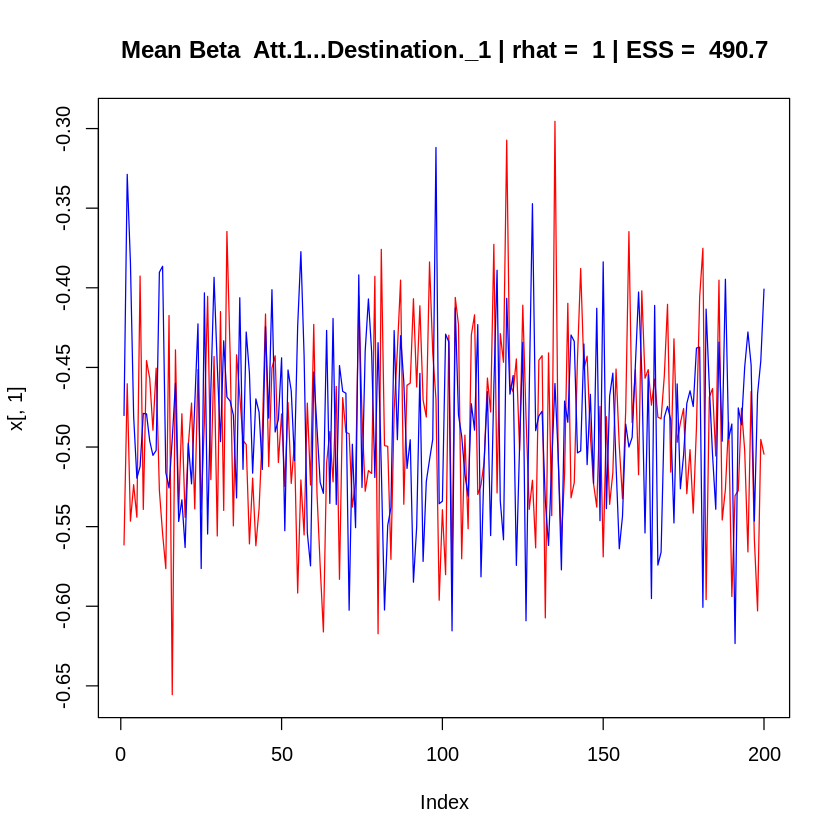

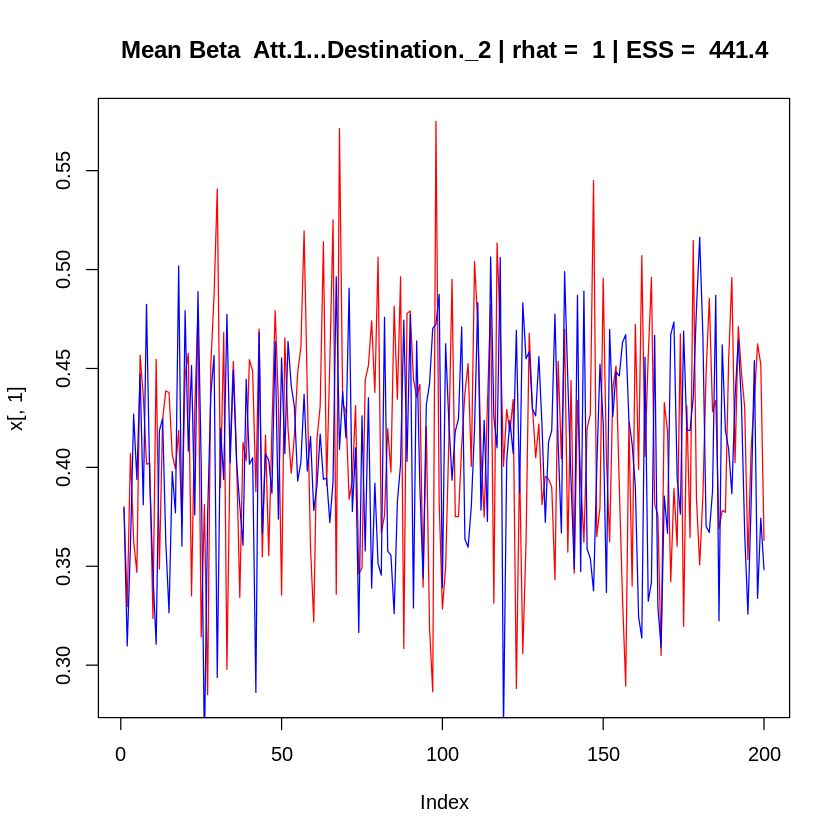

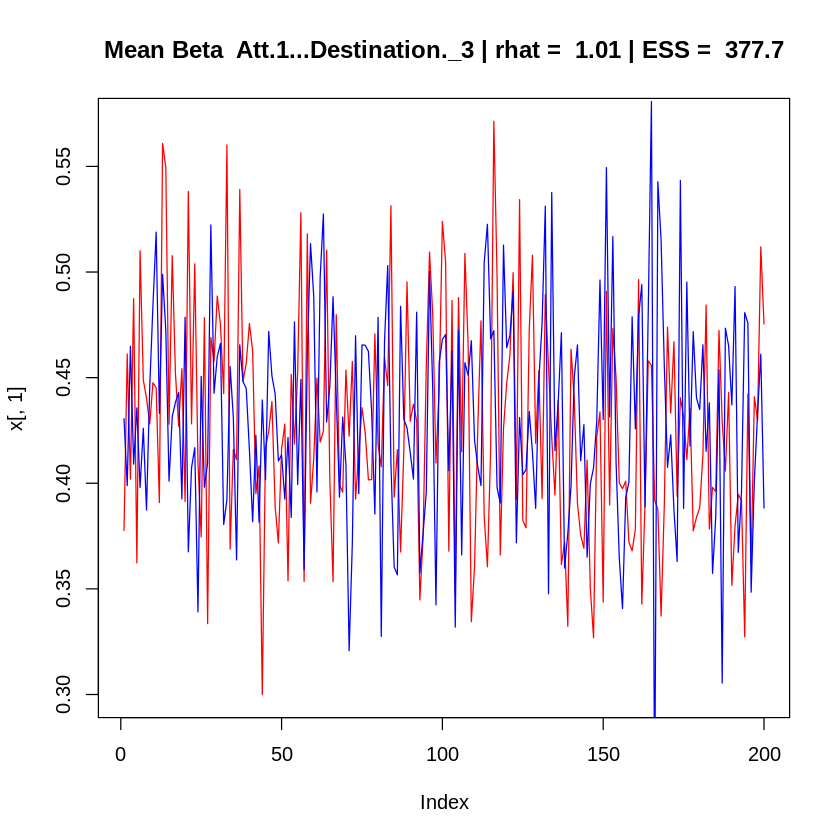

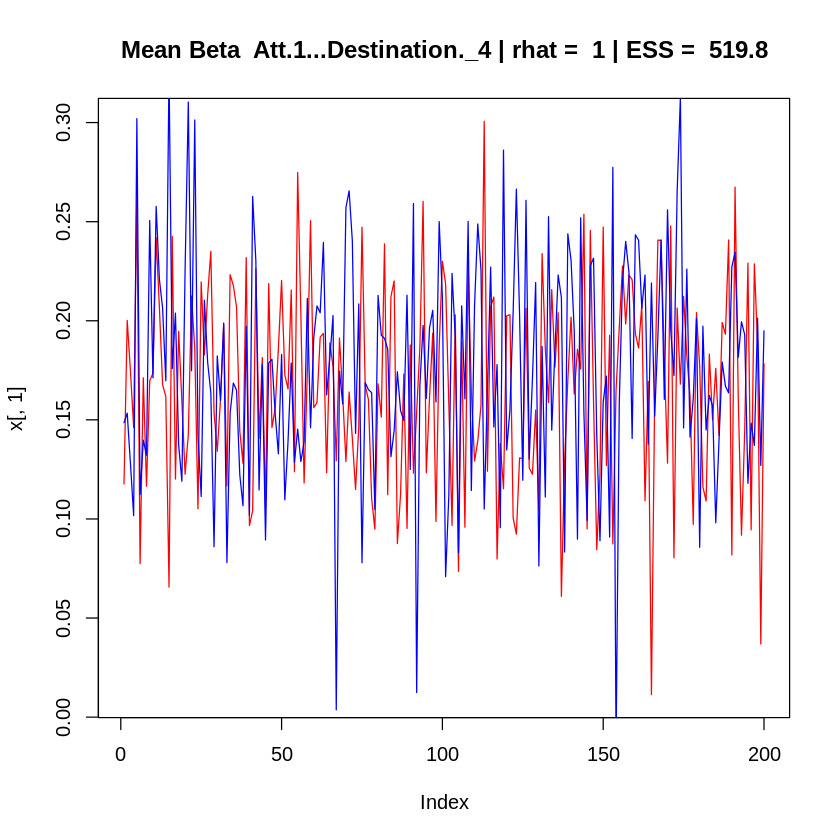

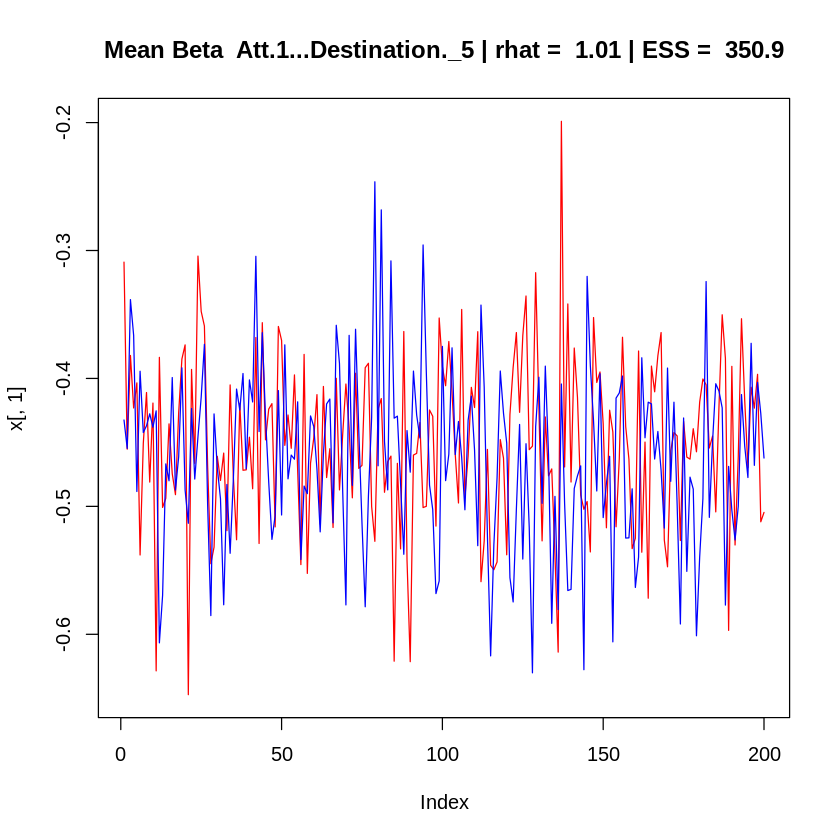

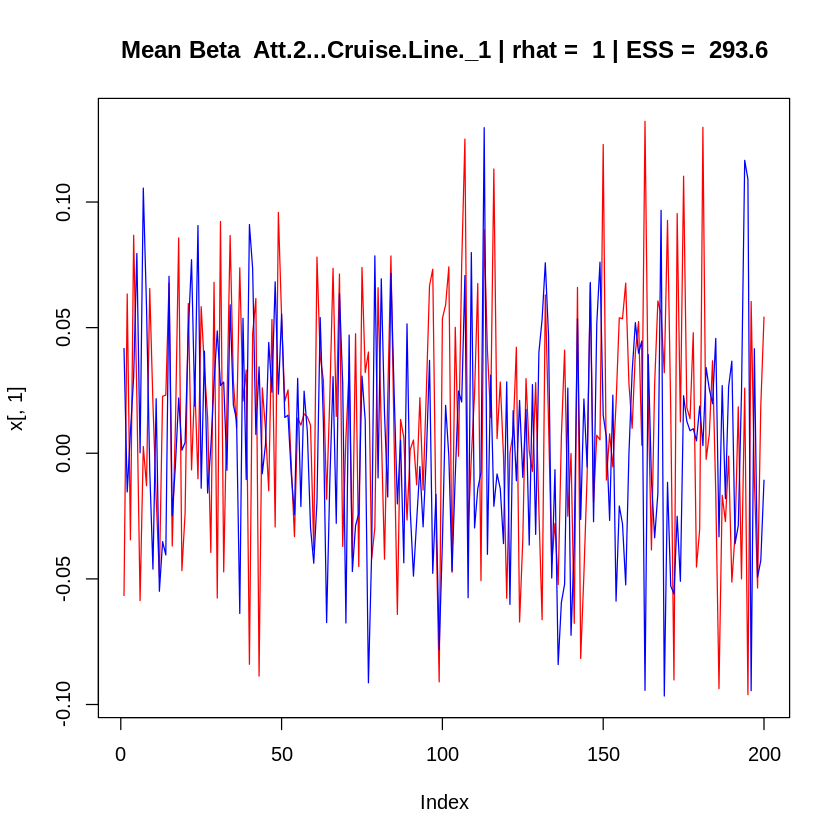

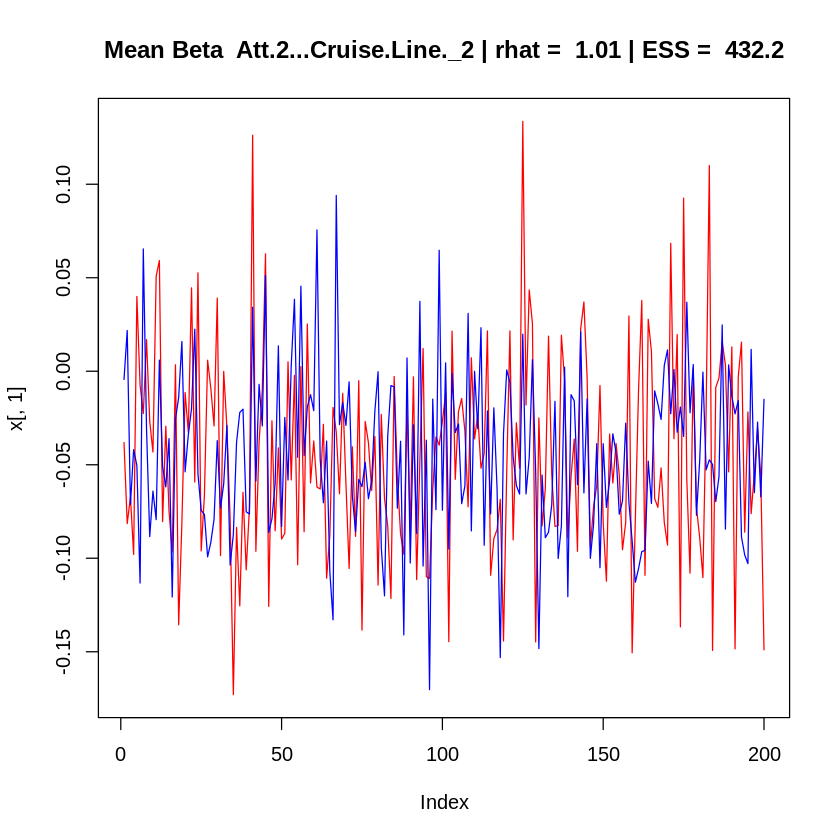

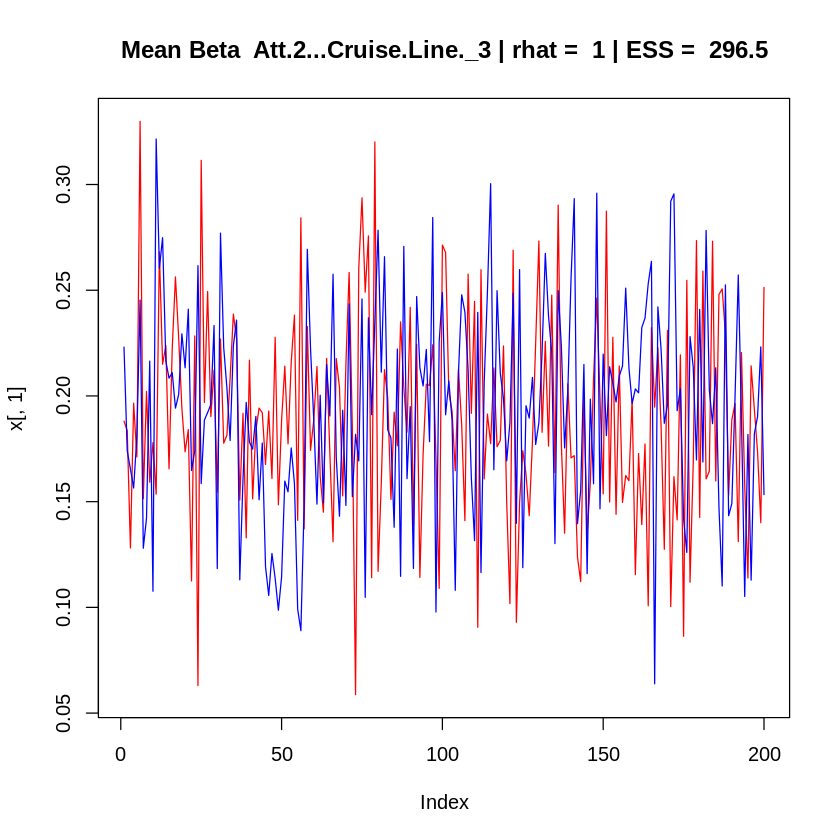

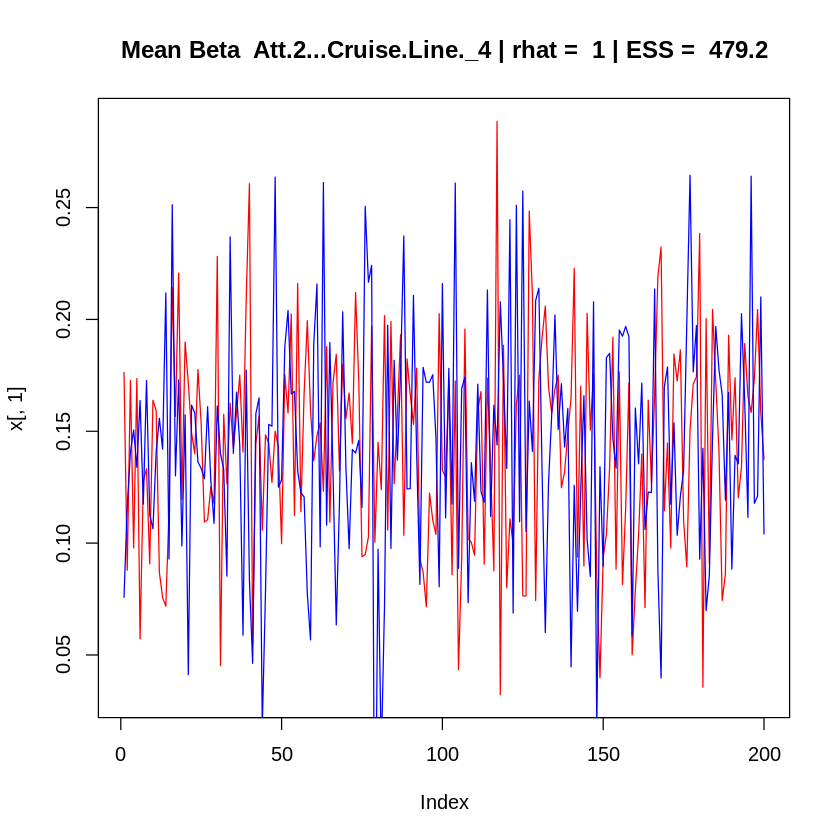

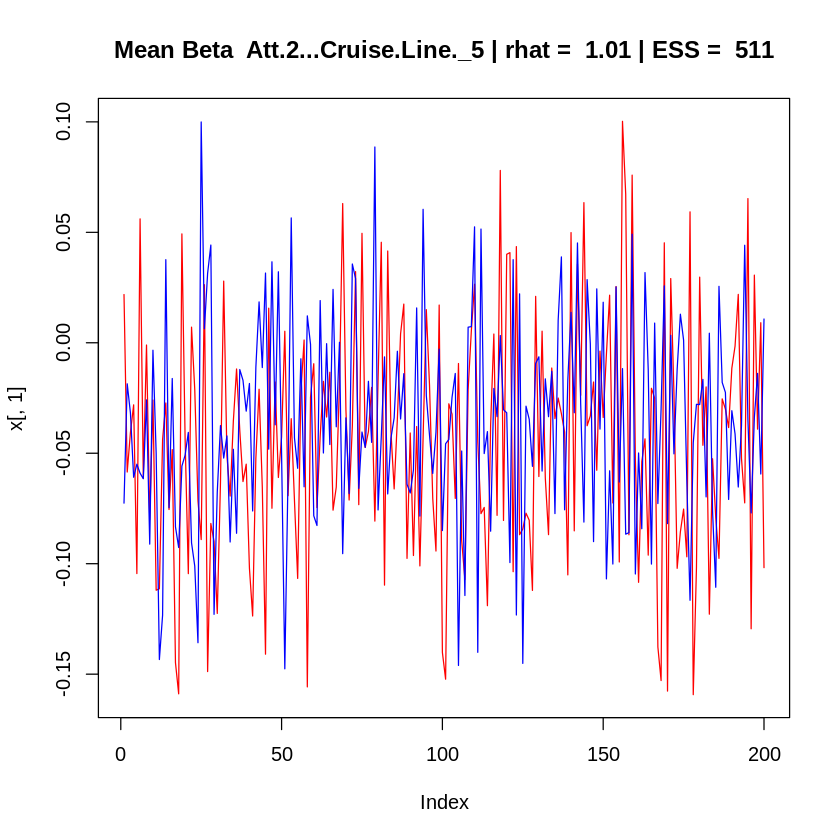

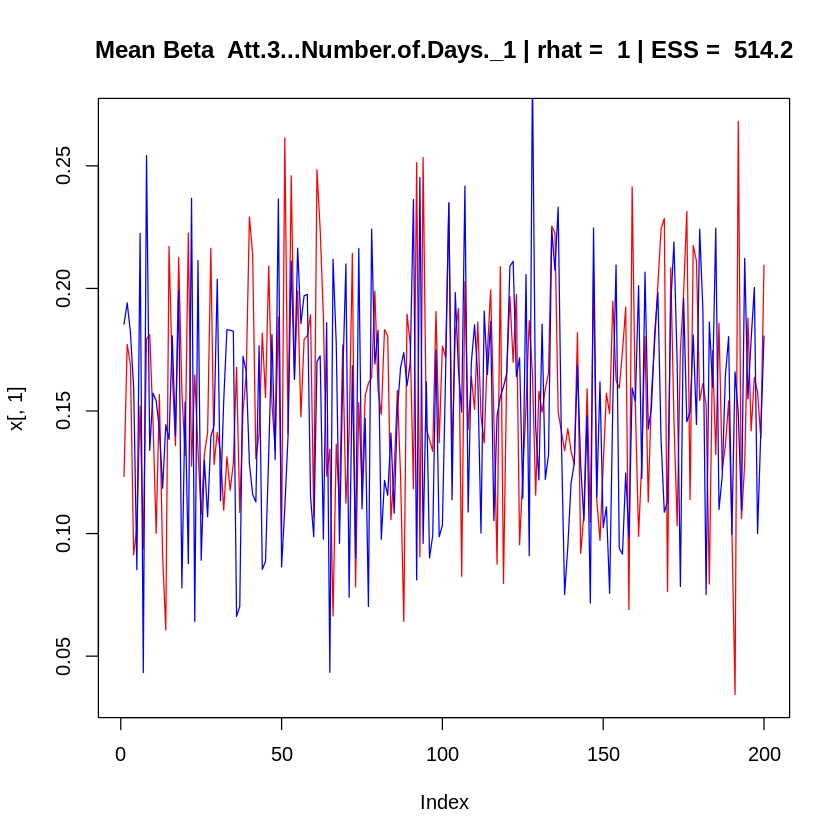

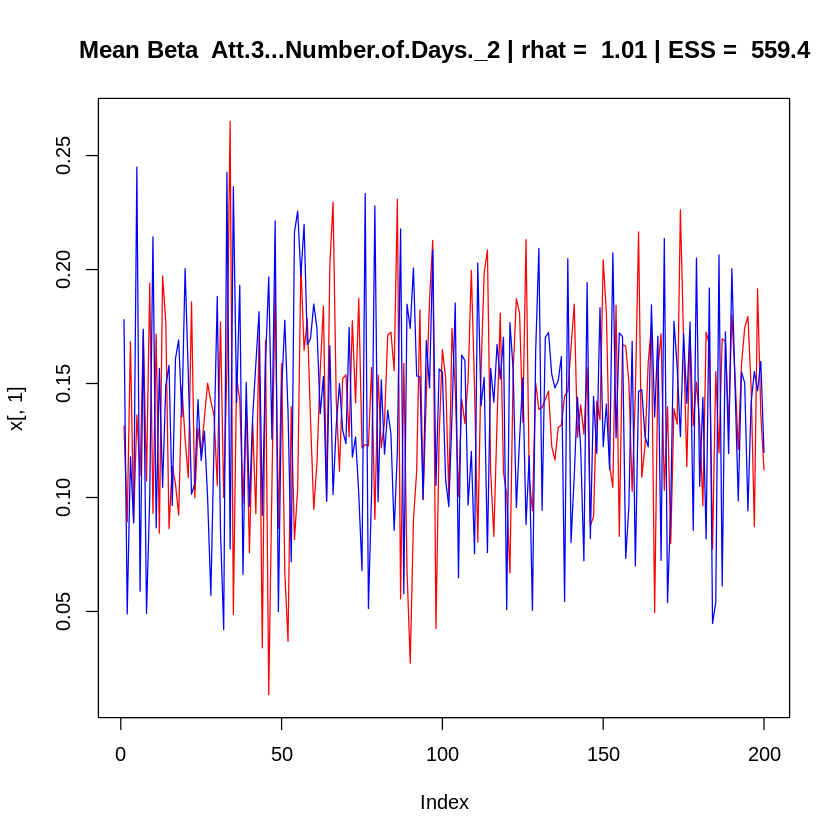

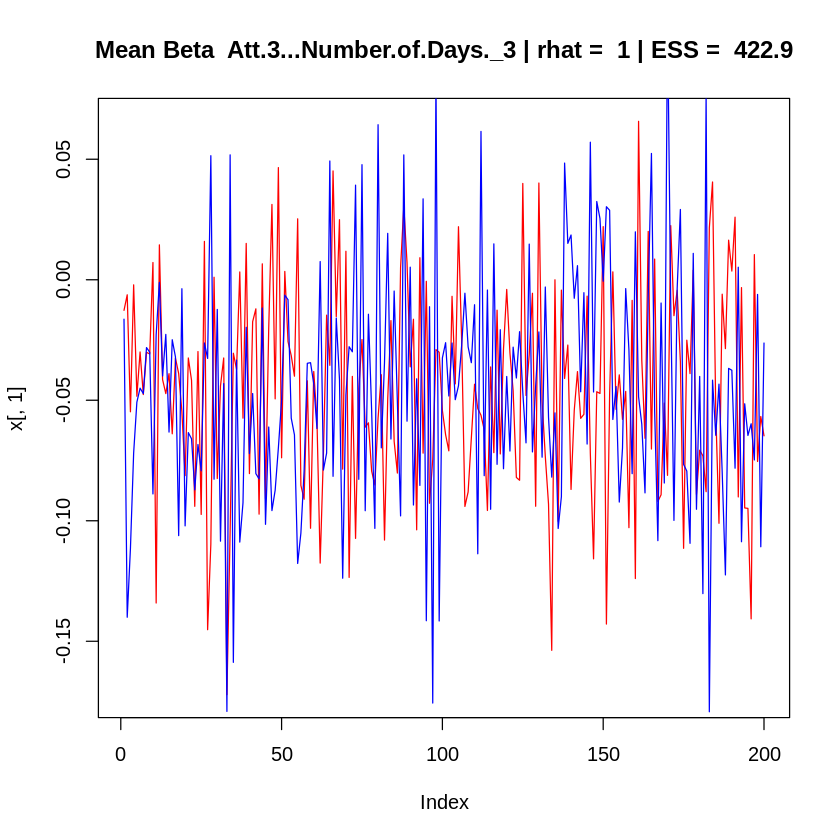

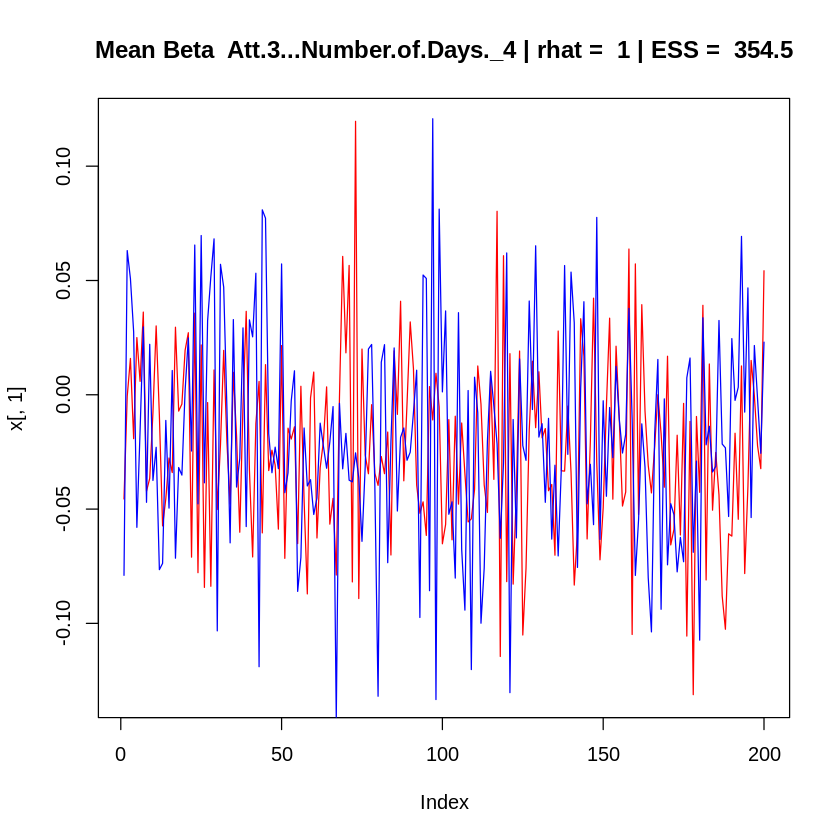

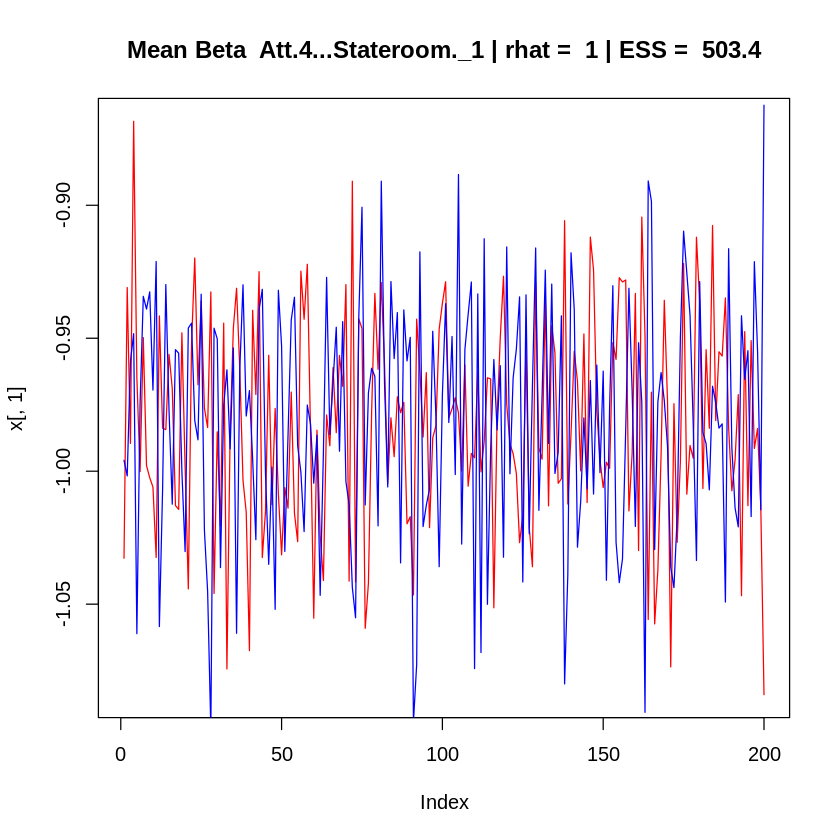

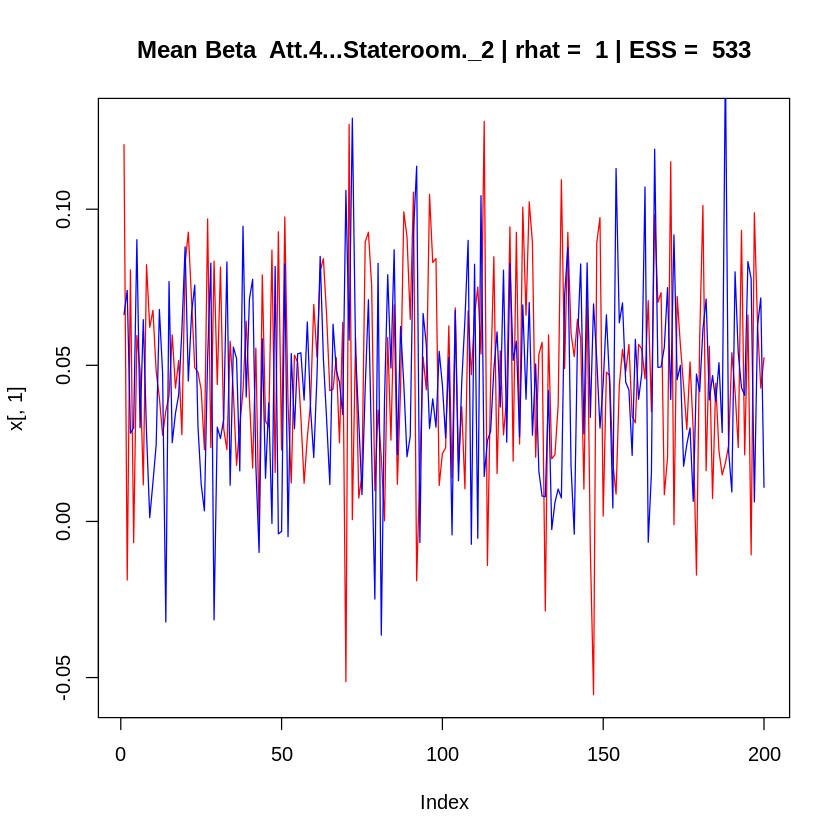

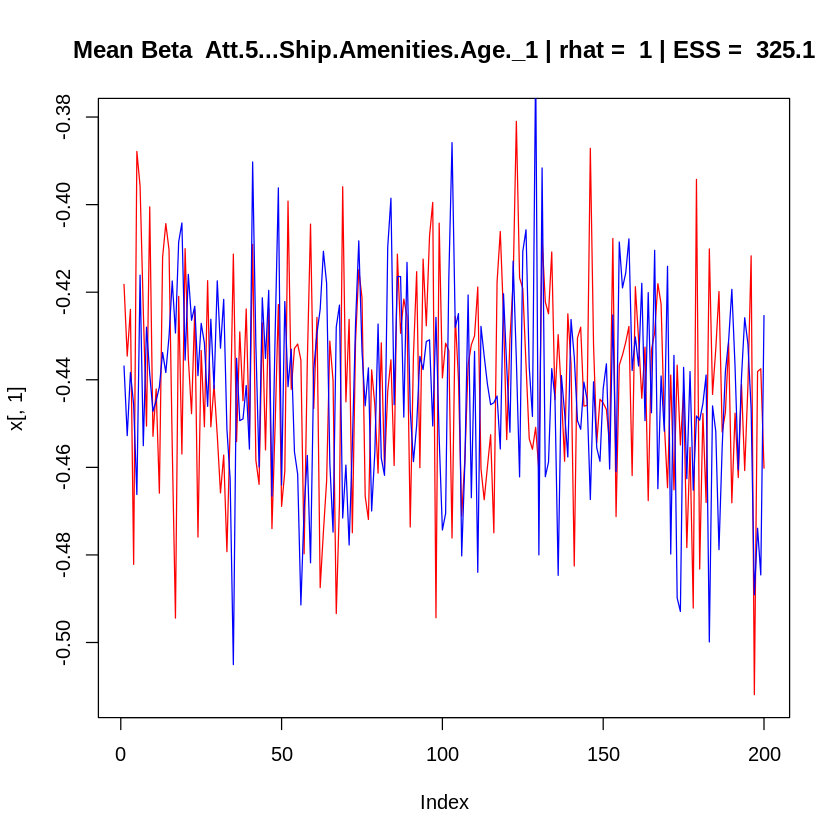

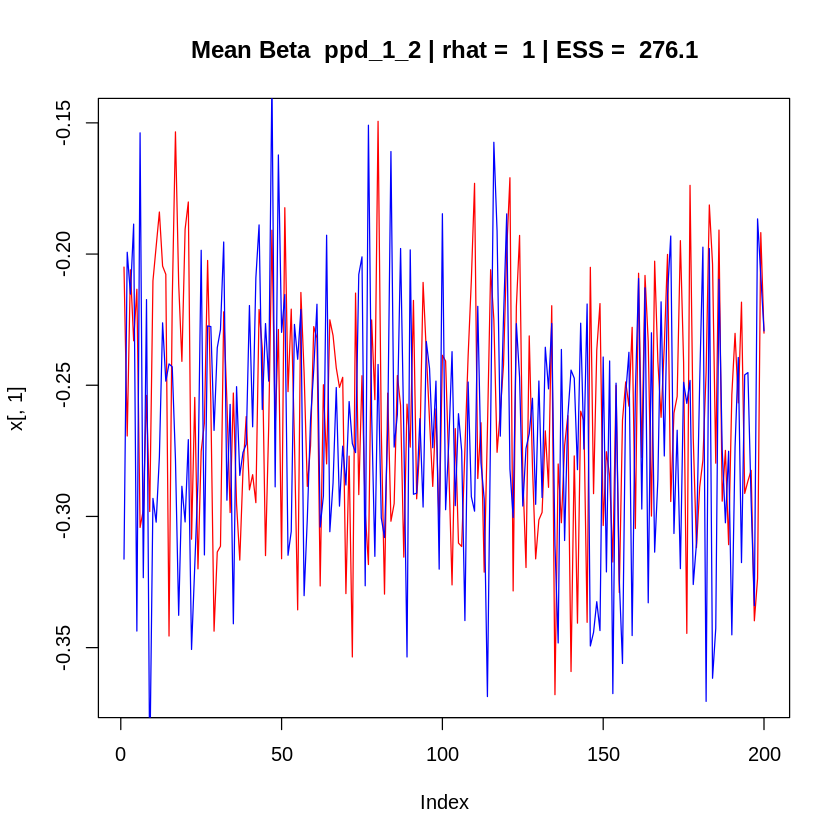

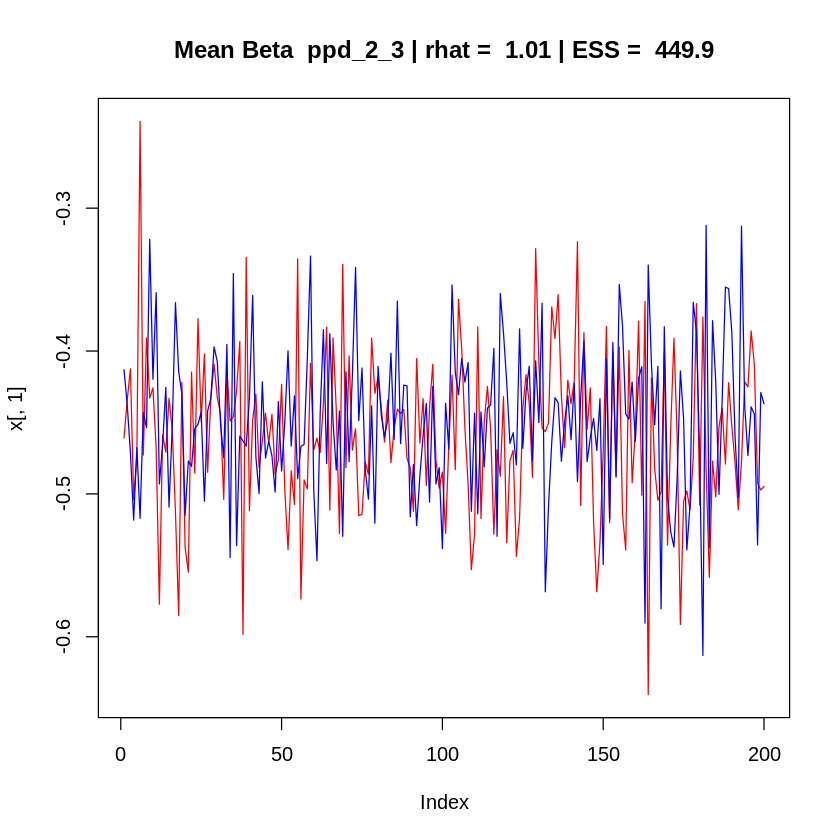

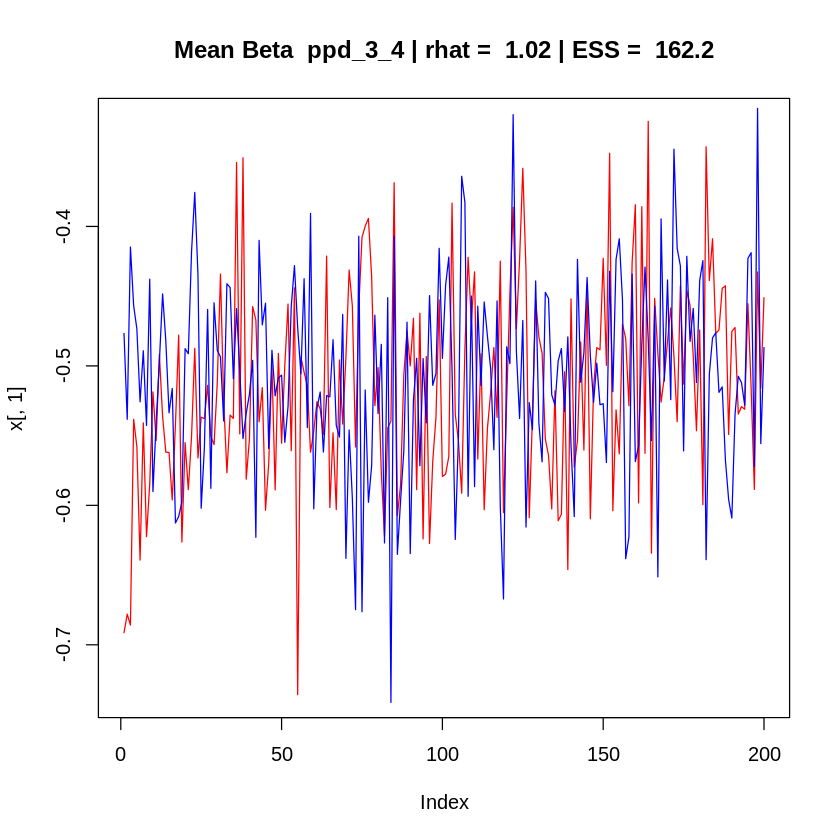

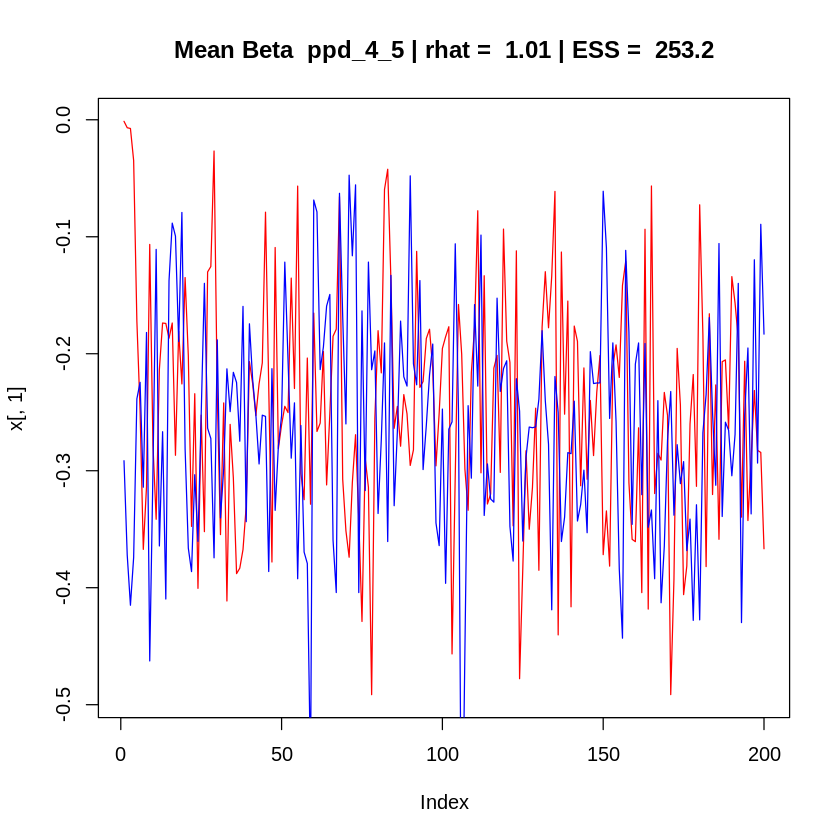

In [ ]:
draws_beta <- read_cmdstan_csv(file.path("/content", csv_name), variables = "beta_ind", sampler_diagnostics = "")
ndraws <- dim(draws_beta$post_warmup_draws)[1]
draws_beta_mu1 <- t(sapply(1:ndraws, function(i){
  beta_mu <- colMeans(matrix(draws_beta$post_warmup_draws[i,1,],data_conjoint$I,data_conjoint$P, byrow = TRUE))  
}))
draws_beta_mu2 <- t(sapply(1:ndraws, function(i){
  beta_mu <- colMeans(matrix(draws_beta$post_warmup_draws[i,2,],data_conjoint$I,data_conjoint$P, byrow = TRUE))  
}))
for (i in 1:ncol(draws_beta_mu1)){
  x <- cbind(draws_beta_mu1[,i],draws_beta_mu2[,i])
  plot(x[,1], type = "l", col = "red", main = paste("Mean Beta ", colnames(data_conjoint$ind)[i],
                                                    "| rhat = ", round(rhat(x),2),
                                                    "| ESS = ", round(ess_basic(x),1)
  ))
  lines(x[,2], type = "l", col = "blue")
}
utilities <- matrix(colMeans(draws_beta$post_warmup_draws, dims = 2),
                    data_conjoint$I, data_conjoint$P, byrow = TRUE)
write.table(utilities, file = file.path("/content", "beta_final_r.csv"), sep = ",", na = ".", row.names = FALSE)
